In [7]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [118]:
def ConvBlock(inputs, filters=64):
    conv1 = keras.layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    batch_norm1 = keras.layers.BatchNormalization()(conv1)
    act1 = keras.layers.ReLU()(batch_norm1)
    conv2 = keras.layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = keras.layers.BatchNormalization()(conv2)
    act2 = keras.layers.ReLU()(batch_norm2)
    return act2
def encoder(inputs, filters=64):
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = keras.layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1
def decoder(inputs, skip, filters=64):
    Upsample = keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = keras.layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out
def get_U_Net(image_size):
    inputs = keras.layers.Input(image_size)
    
    skip1, encoder_1 = encoder(inputs, 32)
    skip2, encoder_2 = encoder(encoder_1, 32*2)
    skip3, encoder_3 = encoder(encoder_2, 32*4)
    skip4, encoder_4 = encoder(encoder_3, 32*4)
    
    conv_block = ConvBlock(encoder_4, 32*4)
    
    decoder_1 = decoder(conv_block, skip4, 32*4)
    decoder_2 = decoder(decoder_1, skip3, 32*4)
    decoder_3 = decoder(decoder_2, skip2, 32*2)
    decoder_4 = decoder(decoder_3, skip1, 32)
    
    outputs = keras.layers.Conv2D(1, kernel_size=(5,5), padding="same", activation="relu")(decoder_4)
    #pool = keras.layers.MaxPooling2D()(outputs)
    
    #flatten = keras.layers.Flatten()(pool)
    #dense = keras.layers.Dense(16*32,  activation="relu")(flatten)
    
    #dense_output = 
    #output = tf.reduce_mean(outputs, axis=-1)(outputs)
    #outputsOne = keras.layers.Conv2D(filters=1, kernel_size=(7,7), activation="relu", padding='same')(outputs)
    #outputsFlat = keras.layers.Reshape((32,32, 1))(dense)
    #anticonv = keras.layers.Conv2DTranspose(1, (3, 3), strides=(2,2), padding='same', activation='relu')(outputsFlat)
    one_channel = keras.layers.Reshape((64,64))(outputs)
    model = keras.models.Model(inputs, one_channel)
    return model

In [9]:
index_list = np.linspace(0,3749, 3750).astype(np.uint16)
np.random.shuffle(index_list)
index_list = index_list
print(index_list)

[1880  821  519 ... 2932  951 2859]


In [10]:
locloc = "BigDataPeople" 
namename = "\Suitman_EEVEE\\SuitMan"
all_photos = np.load(locloc + namename + 'Photos.npy')
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
#all_albedos = np.load(locloc + namename + 'Albedos.npy')
all_depth = np.load(locloc + namename + 'Depth.npy')[:,:,:,0]
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [119]:
locloc = "BigDataPeople" 
namename = "\Knight_EEVEE\\Knight"
all_photos1 = np.load(locloc + namename + 'Photos.npy')
all_depth1 = np.load(locloc + namename + 'Depth.npy')[:,:,:,0]
all_masks1 = np.load(locloc + namename + 'Masks.npy')

In [12]:
locloc = "BigDataPeople" 
namename = "\Woman1_EEVEE\\Woman1"
all_photos2 = np.load(locloc + namename + 'Photos.npy')
all_depth2 = np.load(locloc + namename + 'Depth.npy')[:,:,:,0]
all_masks2 = np.load(locloc + namename + 'Masks.npy')

In [13]:
all_photos = np.concatenate([all_photos, all_photos1, all_photos2], axis=0) 
all_depth = np.concatenate([all_depth, all_depth1, all_depth2], axis=0) 
all_masks = np.concatenate([all_masks, all_masks1, all_masks2], axis=0) 
del all_photos1;  del all_photos2;
del all_depth1;   del all_depth2;
del all_masks1;   del all_masks2;

In [14]:
all_photos = all_photos[index_list]
all_depth = all_depth[index_list]
all_masks = all_masks[index_list]

ratio = 0.96; 
all_length = round( len(all_photos) * ratio)

all_photos_test = all_photos[all_length:]
all_depth_test = all_depth[all_length:]
all_mask_tests = all_masks[all_length:]

all_photos = all_photos[0: all_length]
all_depth = all_depth[0: all_length]
all_masks = all_masks[0: all_length]

In [15]:
all_depth_test.shape

(150, 64, 64)

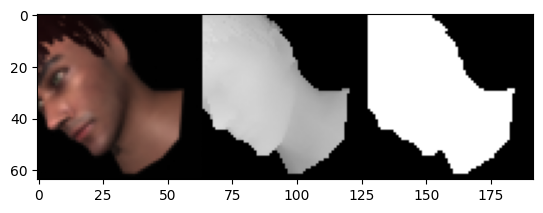

In [16]:
numberouno = 1002
plt.imshow(np.concatenate([all_photos[numberouno], np.stack([all_depth[numberouno],all_depth[numberouno],all_depth[numberouno]], axis=2), all_masks[numberouno]], axis = 1).astype(np.float32))

In [17]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно

dataset = tf.data.Dataset.from_tensor_slices((all_photos, all_depth))

dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape)

(3600, 64, 64, 3)


In [18]:
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(x)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(8*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    

    resh = keras.layers.Reshape((16, 16, 4))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='relu')(resh)
    output = keras.layers.Conv2DTranspose(1, (3, 3), strides=(2,2), padding='same', activation='relu')(anticonv1)
    output = keras.layers.Reshape((64,64))(output)
    # Создание модели
    model = keras.models.Model(inputs=[image_input], outputs=output)
    return model

In [132]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.0000002)

In [126]:

model = get_U_Net((64,64,3))
#model.summary()

model.compile(optimizer=g_optimizer_image, loss='mse')

In [91]:
'''
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.0000)
model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()'''

"\ng_optimizer_image=keras.optimizers.Adam(learning_rate=0.0000)\nmodel = GiveModel()\nmodel.compile(optimizer=g_optimizer_image, loss='mse')\nmodel.summary()"

In [141]:
model.fit(train_dataset, epochs=10)

Epoch 1/10
56/56 [==============================] - 4s 70ms/step - loss: 0.0019
Epoch 2/10
56/56 [==============================] - 4s 69ms/step - loss: 0.0020
Epoch 3/10
56/56 [==============================] - 4s 69ms/step - loss: 0.0018
Epoch 4/10
56/56 [==============================] - 4s 69ms/step - loss: 0.0018
Epoch 5/10
56/56 [==============================] - 4s 69ms/step - loss: 0.0018
Epoch 6/10
56/56 [==============================] - 4s 69ms/step - loss: 0.0017
Epoch 7/10
56/56 [==============================] - 4s 68ms/step - loss: 0.0018
Epoch 8/10
56/56 [==============================] - 4s 68ms/step - loss: 0.0017
Epoch 9/10
56/56 [==============================] - 4s 68ms/step - loss: 0.0021
Epoch 10/10
56/56 [==============================] - 4s 69ms/step - loss: 0.0017


1/1 [==============================] - 0s 26ms/step
(24, 64, 64, 3)


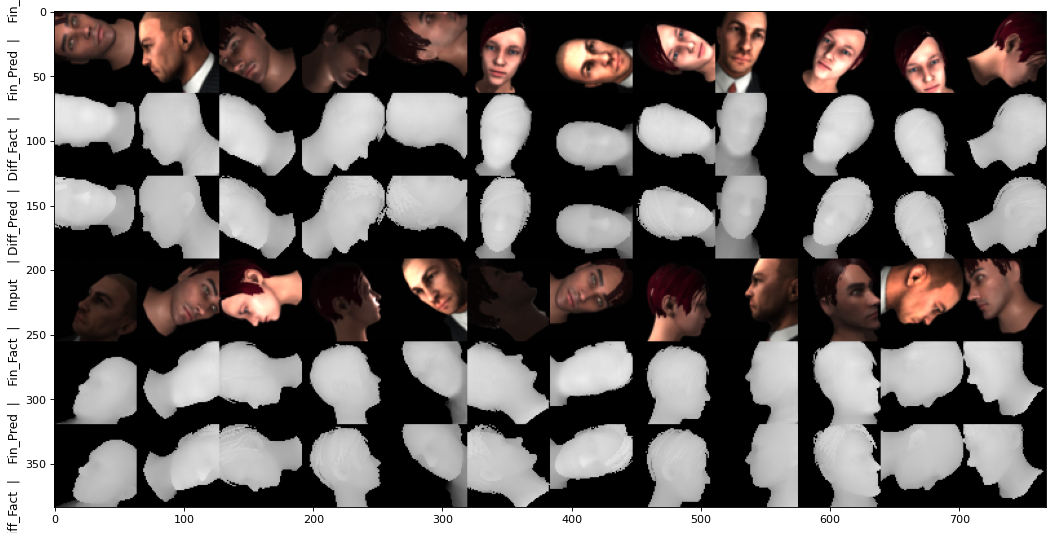

In [142]:
toinset = np.array([i * 25 for i in range(24)])
inputs = all_photos[toinset];  
predictions = model.predict(inputs)
predictions = np.stack([predictions,predictions,predictions], axis =3 )
print(predictions.shape)
loc_depth = all_depth[toinset]
loc_depth = np.stack([loc_depth,loc_depth,loc_depth], axis =3)

final_image = np.concatenate([
    np.concatenate(inputs[0:12], axis=1),
    np.concatenate(predictions[0:12], axis=1),
    np.concatenate(loc_depth[0:12], axis=1),
    np.concatenate(inputs[12:24], axis=1),
    np.concatenate(predictions[12:24], axis=1),
    np.concatenate(loc_depth[12:24], axis=1),
    ], axis = 0
)

plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(final_image.astype("float32").clip(0,1))

In [143]:
model.evaluate(all_photos_test, all_depth_test)

5/5 [==============================] - 0s 19ms/step - loss: 0.0026


0.0025753634981811047

1/1 [==============================] - 0s 23ms/step


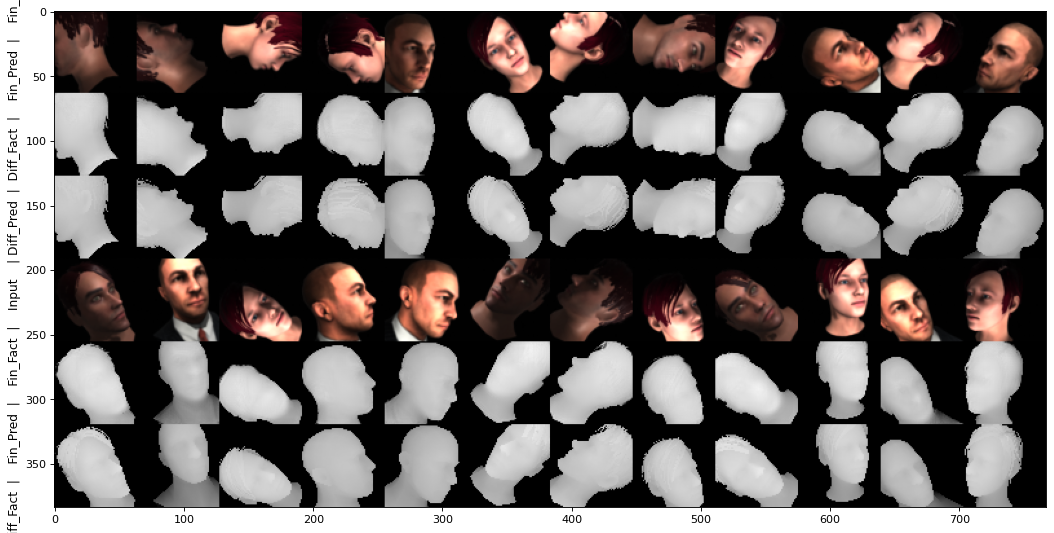

In [144]:
toinset = np.array([i for i in range(24)]); 
test_inputs = all_photos_test[toinset];  
test_depth = all_depth_test[toinset]; 

predictions_test = model.predict(test_inputs)
predictions_test = np.stack([predictions_test,predictions_test,predictions_test], axis = 3)
test_depth = np.stack([test_depth,test_depth,test_depth], axis = 3)
final_image = np.concatenate([
    np.concatenate(test_inputs[0:12], axis=1),
    np.concatenate(predictions_test[0:12], axis=1),
    np.concatenate(test_depth[0:12], axis=1),
    np.concatenate(test_inputs[12:24], axis=1),
    np.concatenate(predictions_test[12:24], axis=1),
    np.concatenate(test_depth[12:24], axis=1),
    ], axis = 0
)

plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(final_image.astype("float32").clip(0,1))

1/1 [==============================] - 0s 21ms/step


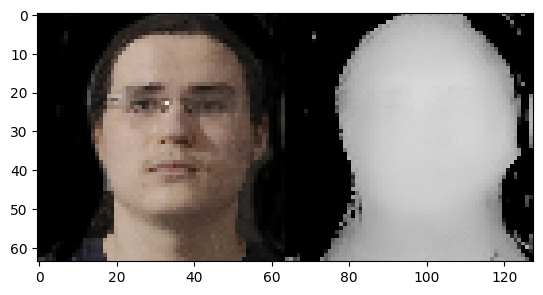

In [146]:
# Вообще работает правильно. Освещенные части оно затемнило, 
# но, из-за того что все картинки в обуч. наборе оранжевые, она затемнила синеватым цветом
dude_pic = Image.open("me.png")
dude_pic = np.array(dude_pic) / 255
dude_depth = model.predict(dude_pic.reshape((1,64,64,3)))[0]
dude_depth = np.stack([dude_depth,dude_depth,dude_depth], axis = 2)
plt.imshow(np.clip(np.concatenate([dude_pic, dude_depth], axis = 1), 0, 1))

In [148]:
#model.save("human_face_UNET_depth_smooth.keras")